# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd
import sqlalchemy as db
import re
import nltk
from nltk.corpus import stopwords
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()
sns.set_context('notebook')

In [3]:
# download stopwords
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [4]:
# load data from database
engine = db.create_engine('sqlite:///../data/DisasterMessages.db')
df = pd.read_sql_table('cleaned_messages', engine)
df.head() 

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# get class names
classes = df.drop(['id', 'message', 'original', 'genre'], axis=1).columns.to_list()

In [6]:
# assign features and labels
X = df['message'].values
y = df.drop(['id', 'message', 'original', 'genre'], axis=1).values

### 1a. Analyze distribution of labels

In [7]:
# analyze distribution of labels
# create dataframe from label array
df_labels = pd.DataFrame(data=y, columns=classes)

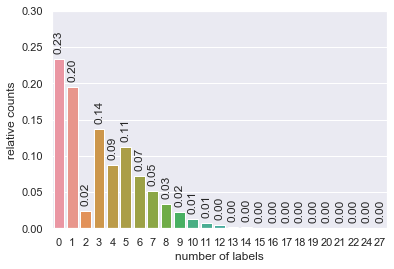

In [8]:
# get counts of entries with a certain number of 
counts = df_labels.sum(axis=1).value_counts().values
relative_counts = counts/y.shape[0]
number_labels = df_labels.sum(axis=1).value_counts().index.values

# sort values and get indices
idx = np.argsort(number_labels)

# plot relative distribution of counts
fig = plt.figure()
sns.barplot(number_labels[idx], counts[idx]/y.shape[0])
plt.ylim(0.0, 0.30)
plt.xlabel('number of labels')
plt.ylabel('relative counts')
for i in range(relative_counts.size):
    plt.text(i, relative_counts[idx][i]+0.01, "%.2f" % (relative_counts[idx][i]),
             rotation=90.0, ha='center')

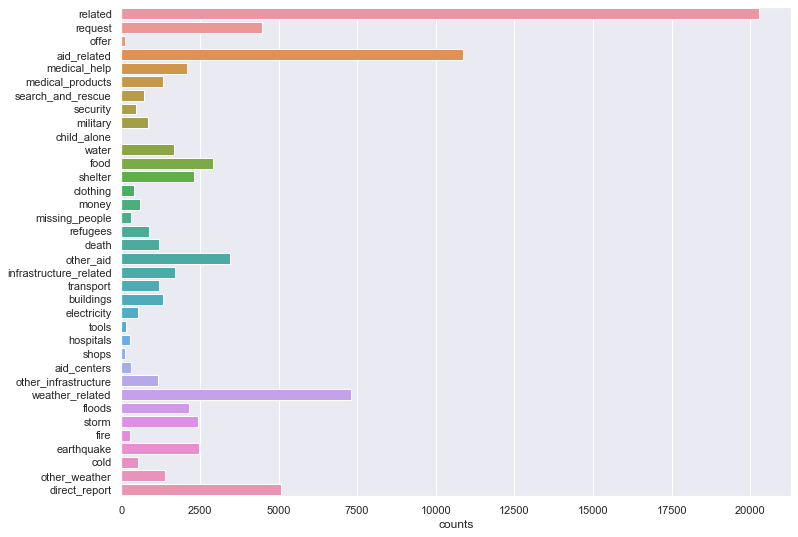

In [9]:
# get distribution of entries ver the different classes
counts = df_labels.sum(axis=0).values
class_labels = df_labels.sum(axis=0).index.to_list()

fig = plt.figure(figsize=(12, 9))
sns.barplot(y=class_labels, x=counts)
plt.xlabel('counts');

#### Observations
* **23%** of all entries are **not labeled**
* more than 95% of all entries are assigned at most 7 labels
* the entries are **distributed unevenly** over the different classes
* the **highest counts** are observed for general labels
    * related
    * aid_related
    * direct_report
    * request
    * other_aid
* other classes with **high counts** are
    * food
    * shelter
    * storm
    * earthquake
* classes with **low counts** are
    * offer
    * child_lost (occurs not at all)
    * tools
    * shops
    * fire

### 2. Write a tokenization function to process your text data

In [10]:
def tokenize(text):
    """
    Processes the provided text input:
    - normalize
    - tokenize
    - remove stopwords
    - lemmatization and stemming
    
    Inputs
    ------
    text : str
        text to process
        
    Returns
    -------
    stemmed : list
        list of processes words in the original text
    """
    # normalize to lower case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize message
    tokens = nltk.tokenize.word_tokenize(text)
    
    # remove stopwors (English)
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    
    # lemmatize and stem words
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    stemmer = nltk.stem.porter.PorterStemmer()
    
    lemmed = [lemmatizer.lemmatize(token) for token in tokens]
    stemmed = [stemmer.stem(lemma) for lemma in lemmed]
    
    return stemmed

In [11]:
for message in X[1815:1820]:
    print(message)
    print(tokenize(message), '\n')

we ask for someone to send us something, anything because there are people starving this moment
['ask', 'someon', 'send', 'u', 'someth', 'anyth', 'peopl', 'starv', 'moment'] 

If anyone has a fracture, he wont be able to go to the dominican republic without a Visa.
['anyon', 'fractur', 'wont', 'abl', 'go', 'dominican', 'republ', 'without', 'visa'] 

Help for the people in Carrefour ( Port au Prince ) zone Waney 89 and 93
['help', 'peopl', 'carrefour', 'port', 'au', 'princ', 'zone', 'waney', '89', '93'] 

Information on flights to Miami.
['inform', 'flight', 'miami'] 

We are waiting for a positive response. Thank you.
['wait', 'posit', 'respons', 'thank'] 



### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [12]:
# construct ML pipeline (choosen clf parameters were optimized via grid search)
steps = [('count', CountVectorizer(tokenizer=tokenize)),
         ('tfidf', TfidfTransformer()),
         ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
        ]

pipeline = Pipeline(steps=steps)

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [13]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [14]:
# fit pipeline
pipeline.fit(X_train, y_train)

/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

Pipeline(memory=None,
         steps=[('count',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize a...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [15]:
# predict classes on test set
y_pred = pipeline.predict(X_test)

In [16]:
# define function to report model scores for each class
def report_model_scores(tests, predictions, classes):
    """
    Report precision, recall, and f1 scores for each class
    
    Parameters
    ----------
    tests : ndarray
        true labels
        
    predictions : ndarray
        predicted labels
        
    classes : list
        classes
        
    Returns
    -------
    scores : ndarray
        array of calculated scores (class in row, scores in columns: precision, recall, f1)
    """
    # get number of classes and initialize scores array
    n_classes = len(classes)
    scores = np.zeros((n_classes, 3))
    
    # calculate precision, recall, and f1 for each class
    for i in range(n_classes):
        scores[i, 0] = precision_score(tests[:, i], predictions[:, i], average='macro')
        scores[i, 1] = recall_score(tests[:, i], predictions[:, i], average='macro')
        scores[i, 2] = f1_score(tests[:, i], predictions[:, i], average='macro')
    
    # sort scores in ascending order by f1 score
    idx = np.argsort(scores, axis=0)[:, 0]
    
    # print scores for each class in ascending order
    for i in range(n_classes):
        print("{0:25s}{1:.2f}\t{2:.2f}\t{3:.2f}".format(classes[idx[i]], scores[idx[i], 0],
                                                        scores[idx[i], 1], scores[idx[i], 2]))
    
    # calculate and print average scores
    averages = np.average(scores, axis=0)
    print("\n{0:25s}{1:.2f}\t{2:.2f}\t{3:.2f}".format("MACRO AVG", averages[0], averages[1], averages[2]))
    
    return scores

In [18]:
# test function to report model scores
scores = report_model_scores(y_test, y_pred, classes)

/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

aid_related              0.75	0.75	0.75
related                  0.79	0.80	0.79
other_aid                0.82	0.87	0.82
direct_report            0.83	0.84	0.82
weather_related          0.86	0.86	0.86
request                  0.88	0.89	0.87
infrastructure_related   0.88	0.94	0.91
medical_help             0.90	0.92	0.89
other_infrastructure     0.92	0.96	0.94
shelter                  0.92	0.93	0.92
other_weather            0.92	0.95	0.93
storm                    0.93	0.93	0.93
food                     0.93	0.94	0.93
medical_products         0.94	0.95	0.93
transport                0.94	0.96	0.94
water                    0.95	0.95	0.94
floods                   0.95	0.95	0.94
buildings                0.95	0.95	0.94
refugees                 0.95	0.97	0.95
death                    0.95	0.96	0.95
military                 0.96	0.97	0.96
search_and_rescue        0.96	0.98	0.97
earthquake               0.97	0.97	0.97
security                 0.97	0.98	0.97
electricity              0.97	0.98	0.97


### 6. Improve your model
Use grid search to find better parameters. 

In [19]:
# AdaBoost parameters
#parameters = {
#    'clf__estimator__n_estimators': [10, 20, 50, 100],
#    'clf__estimator__learning_rate': [0.01, 0.1, 0.5, 0.8]
#}

# RandomForest parameters
parameters = {
   'clf__estimator__n_estimators': [50, 100, 200],
   'clf__estimator__min_samples_split': [2, 10, 50, 100]
}

cv = GridSearchCV(pipeline, param_grid=parameters, refit=True, n_jobs=2)

# uncomment next line to run full grid search (takes some time due to full 3-fold cross-validation)
cv.fit(X_train, y_train)

/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('count',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                      

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [20]:
# make predictions for test set using optimized classifier
y_pred_opt = cv.predict(X_test)
scores = report_model_scores(y_test, y_pred_opt, classes)

/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/larskiewidt/anaconda3/envs/datasci/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

aid_related              0.77	0.77	0.77
related                  0.80	0.81	0.79
other_aid                0.82	0.87	0.81
direct_report            0.83	0.85	0.82
weather_related          0.88	0.88	0.88
infrastructure_related   0.88	0.94	0.91
request                  0.89	0.89	0.88
medical_help             0.91	0.92	0.89
other_infrastructure     0.92	0.96	0.94
other_weather            0.93	0.95	0.93
storm                    0.93	0.94	0.94
shelter                  0.93	0.94	0.93
food                     0.94	0.94	0.93
medical_products         0.94	0.95	0.93
transport                0.95	0.96	0.94
buildings                0.95	0.95	0.94
refugees                 0.95	0.97	0.95
floods                   0.95	0.95	0.95
water                    0.95	0.96	0.95
death                    0.96	0.96	0.95
military                 0.96	0.97	0.96
search_and_rescue        0.96	0.98	0.97
earthquake               0.97	0.97	0.97
security                 0.97	0.98	0.97
aid_centers              0.98	0.99	0.98


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

> other ML algorithms (e.g. AdaBoost) were tried above

### 9. Export your model as a pickle file

In [25]:
# save trained model with pickle
model_pkl = open('message_classifier.pkl', 'wb')
pickle.dump(cv, model_pkl)
model_pkl.close()

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.